In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import seaborn as sns
import scipy
import random

from sklearn import cluster
from sklearn.metrics.pairwise import pairwise_distances

# This is importing a "future" python version 3 print function.
from __future__ import print_function
from __future__ import division
%matplotlib inline
sns.set()
sns.set_context('paper', font_scale = 1.5)
sns.set_style('ticks')

/Users/Franklin/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
def kMedoids(D, k, tmax=100):
    # determine dimensions of distance matrix D
    m, n = D.shape

    # randomly initialize an array of k medoid indices
    M = np.sort(np.random.choice(n, k))

    # create a copy of the array of medoid indices
    Mnew = np.copy(M)

    # initialize a dictionary to represent clusters
    C = {}
    for t in xrange(tmax):
        # determine clusters, i. e. arrays of data indices
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]
        # update cluster medoids
        for kappa in range(k):
            J = np.mean(D[np.ix_(C[kappa],C[kappa])],axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]
        np.sort(Mnew)
        # check for convergence
        if np.array_equal(M, Mnew):
            break
        M = np.copy(Mnew)
    else:
        # final update of cluster memberships
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

    # return results
    return M, C

Compute a Medoid for every user.

In [4]:
file_dir = '/Volumes/1TB_BAY/yelp_dataset_challenge_academic_dataset/'

r = pd.read_csv(file_dir + 'review_without_text_year.csv')
b = pd.read_csv('yelp_business_with_neighborhood.csv')
u = pd.read_csv(file_dir + 'yelp_academic_dataset_user.csv')

/Users/Franklin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2,5,30,50,61,63,80,87,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [40]:
s = pd.read_csv('static_stats.csv')

In [5]:
rb = pd.merge(r,b, on = 'business_id', how = 'inner')
rbu = pd.merge(rb, u, on = 'user_id', how = 'inner')

In [10]:
rm = pd.read_csv(file_dir + 'review_metrics.csv', delim_whitespace = True, header = None)
rm.rename(columns = {1: 'review_id', 2: 'words', 3: 'sentences', 4: 'ease', 5: 'grade', 6: 'dale_chall'}, inplace = True)

In [15]:
rmbu = pd.merge(rbu, rm, on = 'review_id', how = 'inner')

In [20]:
user_hood = [] #create empty list to store user neighborhood info
check_i = 0

for user in np.unique(rmbu['user_id']):
    
    myfile = open('user_hood3.txt','a')
    
    check_i = check_i + 1
    #print('User Number: ' + str(check_i))
    
    user_reviews = rmbu[(rmbu['user_id'] == user)]
    location_data = user_reviews[['longitude','latitude']].as_matrix() #pull out locations of reviewed restaurants
    D = pairwise_distances(location_data, metric='euclidean')  # distance matrix
    M, C = kMedoids(D, 1) # perform kmedoid, with one cluster
    
    match = int(user_reviews['z_hood'].as_matrix()[M])
    pct_match = len(user_reviews[(user_reviews['z_hood'] == match)])/len(user_reviews)
                
    #print(pct_match)
    
    
                
    w_line = np.hstack((np.unique(user_reviews['user_id'])[0], match, pct_match, len(user_reviews),\
                       np.mean(user_reviews['words']), np.std(user_reviews['words']),\
                       np.mean(user_reviews['sentences']), np.std(user_reviews['sentences']),\
                       np.mean(user_reviews['ease']), np.std(user_reviews['ease']),\
                       np.mean(user_reviews['grade']), np.std(user_reviews['grade']),\
                       np.mean(user_reviews['dale_chall']), np.std(user_reviews['dale_chall'])))
    
    np.savetxt(myfile, w_line, newline = ' ',fmt = '%s', delimiter = ',')
    myfile.write('\n')
    myfile.close()

In [85]:
u = pd.read_csv(file_dir + 'yelp_academic_dataset_user.csv')
uh = pd.read_csv('user_hood2.txt', header = None, delim_whitespace = True)
uh.rename(columns = {0: 'user_id', 1:'z_hood',2:'frac_in_hood', 3: 'n_reviews',\
                    4: 'mean_words', 5:'std_words',\
                    6: 'mean_sentences', 7: 'std_sentences',\
                    8: 'mean_ease', 9: 'std_ease',\
                    10: 'mean_grade', 11: 'std_grade',\
                    12: 'mean_dc', 13: 'std_dc'}, inplace = True)

In [118]:
uf  = u[(u['n_reviews'] >= 5) & (u['frac_in_hood'] >= 0.50)]
uf = pd.merge(uf, s, on = 'z_hood', how = 'inner' )
print(len(uf))

13352


(4, 10)

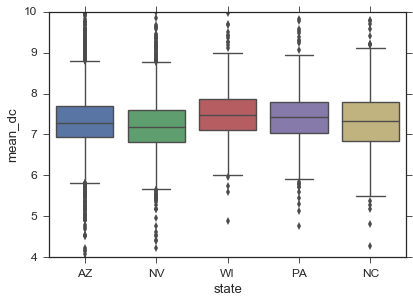

In [122]:
sns.boxplot(data = uf, x = 'state', y = 'mean_dc')
plt.ylim(4,10)

(4, 10)

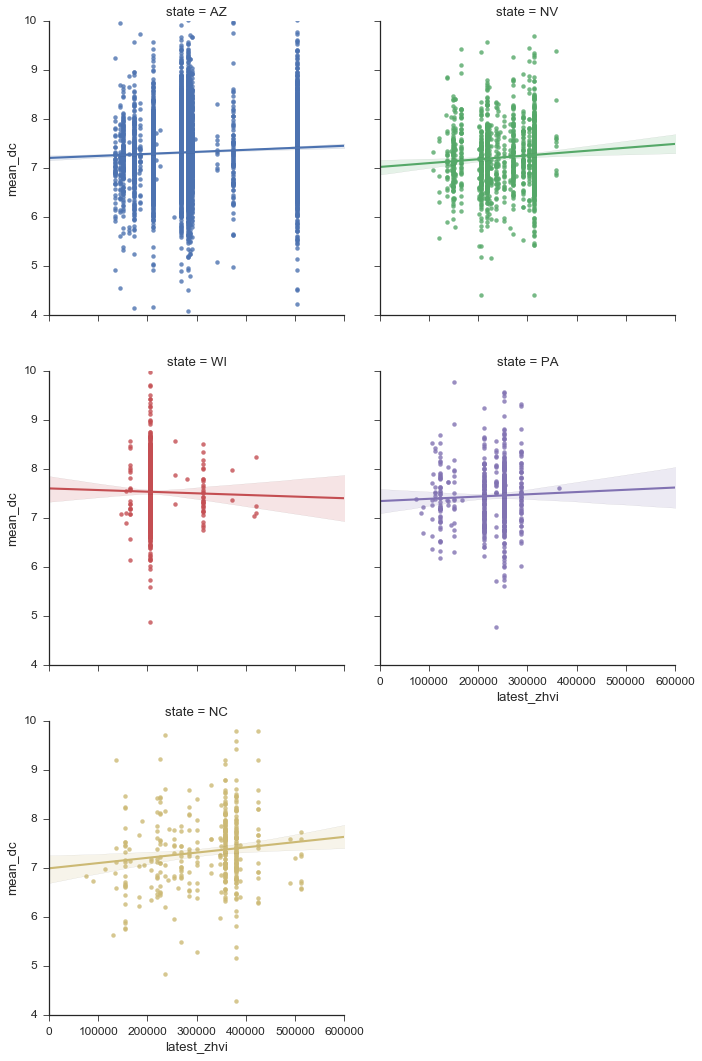

In [120]:
sns.lmplot(data = uf, x = 'latest_zhvi', y = 'mean_dc',\
           col = 'state', hue = 'state',  col_wrap = 2)
plt.xlim(0,600000)
plt.ylim(4,10)